# aside_EDA_winning_rate_per_time.ipynb
> - 시간별 위닝레이트만 다른 방법으로 계산을 해봄
> - (1) 시간별 누적 counts
> - (2) 10분 단위 구간 counts

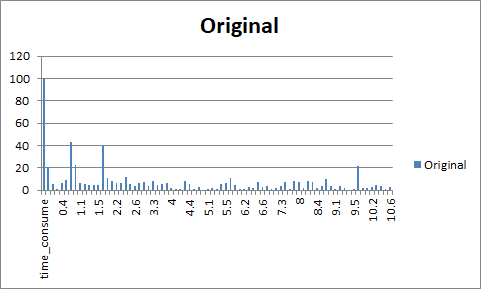

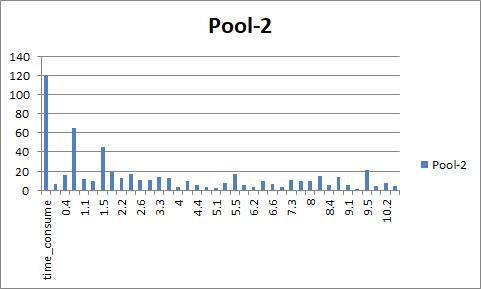

## Pool-4 를 기준으로 P0_winning_rates 를 만듬!
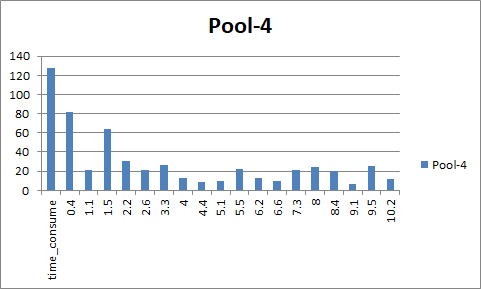

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import multiprocessing as mp

from parse import *
from multiprocessing import Pool

num_cores = mp.cpu_count()               # cpu의 코어 수를 반환
print(f"THIS CPU CORES ARE .. = {num_cores} CORES!")        # CPU CORES = 16 CORES!

THIS CPU CORES ARE .. = 16 CORES!


In [3]:
"""
# 기본 DIR 구조를 입력한다. - _assets 폴더 제외!
# /content/drive/My Drive/Colab Notebooks/
# dir_base = '/content/drive/My Drive/Colab Notebooks/competition/''
"""
dir_base = '/home/yk/0325_Starcraft/competition/'

raw      = 'c03_starcraft_prediction/data_raw/'
remake   = 'c03_starcraft_prediction/data_remake/'
submit   = 'c03_starcraft_prediction/data_submit/'

assets = '/home/yk/0325_Starcraft/competition/_assets'

In [4]:
"""
# 모듈 import를 위한 SYS.PATH 설정!
"""
import os
import sys

if not dir_base in sys.path:
    sys.path.insert(0, dir_base)
    print(f"***'{dir_base}' has set in SYS.PATH! ***")    
    print()
    
for i, item in enumerate(sys.path,1):
    print(f"{i:02}.{item}")

***'/home/yk/0325_Starcraft/competition/' has set in SYS.PATH! ***

01./home/yk/0325_Starcraft/competition/
02./home/yk/0325_Starcraft/competition/c03_starcraft_prediction
03./home/yk/anaconda3/lib/python37.zip
04./home/yk/anaconda3/lib/python3.7
05./home/yk/anaconda3/lib/python3.7/lib-dynload
06.
07./home/yk/anaconda3/lib/python3.7/site-packages
08./home/yk/anaconda3/lib/python3.7/site-packages/IPython/extensions
09./home/yk/.ipython


### 사용함수의 정의

In [5]:
from tqdm import tqdm

from _assets.modules import ( __doc__, 
                                show_ls, 
                                show_infoDF_from,
                                histit,
                                hist_it,
                                plot_it,
                                get_random_n_array,
                                get_basic_df,
                                get_counts_dict_fromDF,
                            )


# OS 화일 및 DF 정보조회를 위한 탐색 모듈



## 이벤트 Detail 탐색을 위해 각 이벤트 딕트를 만든다
- df_train 을 읽어들인다 = 모든 분류소스의 오리지널 화일
- 이벤트 탐색을 위한 counts 이벤트 딕트를 만든다, 
- 각 이벤트를카운트한 시리즈

In [8]:
%%time
df_train = pd.read_csv(dir_base + raw + 'train.csv')

CPU times: user 41.7 s, sys: 3.8 s, total: 45.5 s
Wall time: 42.7 s


## 구간별 승리횟수 Counts 로 P0가 유리한 구간대를 찾아낸다
- 10분 단위 구간이라도, count 횟수가 크게 달라진다.
- count 수가 많은 경우 = 정규화가 많이 진행될수 있으니
- 어떻게 고려해 줘야 할까??? --- 고민 중!

In [9]:
%%time
"""
# df_time 데이터를 만든다. = 유니크 게임 갯수 *** DATA SHAPE = [ 38,872 x 1 ]
"""

df_time = pd.DataFrame(columns=['game_id'])       # 빈 df 선언
df_time['game_id'] = df_train['game_id'].unique() # 빈 df 에 'game_id 를 채운다
df_time['time_consum'] = np.array(df_train[df_train.shift(-1).game_id != df_train.game_id].time)

CPU times: user 10.8 s, sys: 3.58 s, total: 14.4 s
Wall time: 4.68 s


In [10]:
df_time.shape                         # (38872, 2) *** DATA SHAPE = [ 38,872 x 2 ]
df_time.head(3)

,game_id,time_consum
0,0,7.24
1,1,9.59
2,2,9.59


In [11]:
show_ls(dir_base + remake )

False
DIR_TARGET=/home/yk/0325_Starcraft/competition/c03_starcraft_prediction
/home/yk/0325_Starcraft/competition/c03_starcraft_prediction/data_remake/
----------------------------------------
  01. .ipynb_checkpoints
  02. accumulated_winning_rate_per_time.csv
  03. df_win_rate_every_10sec.csv
  04. df_win_rate_every_20sec.csv
  05. df_win_rate_every_40sec.csv
  06. df_xtest_remake.csv
  07. df_xtrain_remake.csv
  08. df_ytrain_remake.csv


In [12]:
df_win = pd.read_csv(
                dir_base + remake + 'df_ytrain_remake.csv', 
                index_col='Unnamed: 0', 
                # index = np.arange(38872),
                # names=['game_id','winner'],
            )

dfs = [df_time, df_win]
cols = ['time_consum','P0_win','P1_win']

df_winning = pd.concat(dfs, axis=1, join='outer')
df_winning['P1_win'] = df_winning['winner'].apply(lambda x: int(not x) )
df_winning = df_winning.rename(columns={"winner": "P0_win",})
df_winning = df_winning[cols]
df_winning

,time_consum,P0_win,P1_win
0,7.24,1,0
1,9.59,1,0
2,9.59,0,1
3,9.59,0,1
4,5.43,0,1
...,...,...,...
38867,8.22,1,0
38868,9.59,0,1
38869,8.25,0,1
38870,5.56,1,0


In [15]:
df_winning.time_consum.min() # 0.08
df_winning.time_consum.max() # 10.59

10.59

In [16]:
def get_time_seg(interval=0.1):
    time_seg = [(time/10) 
                     for time in range(0, 110, int(interval * 10))
                     if not str(time/10).split('.')[1] in ['7','8','9']
                ]
    if time_seg[-1] != 10.6:
        time_seg.pop()
        time_seg.append(10.6)

    if time_seg[0] == 0:
        time_seg.pop(0)
    
    return time_seg    

time_seg01 = get_time_seg(interval=0.1)        
time_seg02 = get_time_seg(interval=0.2)
time_seg04 = get_time_seg(interval=0.4)

print(time_seg01[:5],time_seg01[-5:], f"= {len(time_seg01)}")     # FOR TEST!
print(time_seg02[:5],time_seg02[-5:], f"= {len(time_seg02)}")     # FOR TEST!
print(time_seg04[:5],time_seg04[-5:], f"= {len(time_seg04)}")     # FOR TEST!

[0.1, 0.2, 0.3, 0.4, 0.5] [10.2, 10.3, 10.4, 10.5, 10.6] = 76
[0.2, 0.4, 0.6, 1.0, 1.2] [9.6, 10.0, 10.2, 10.4, 10.6] = 43
[0.4, 1.2, 1.6, 2.0, 2.4] [8.4, 9.2, 9.6, 10.0, 10.6] = 21


In [17]:
def get_counts(df, time_end, time_interval = 0.1):
    """ HELPER() for get_win_rates() BELOW """
    win_count = df['P0_win'][
                    (df['time_consum'] > (time_end - time_interval)) &
                    (df['time_consum'] <= time_end)
                ].value_counts()
    if list(win_count) == [4] : win_count = (4,0)  # 예와적인 처리가 필요 함!
    return list(win_count) 


def get_win_rates(df, time_segs, time_interval=0.1):
    """ df= df_winning"""
    win_rates = []
    for sec in tqdm(time_segs):
        _ = get_counts(df, sec, time_interval)

        delta_win = _[0] - _[1]
        P0_rate = (_[0]/(_[0] + _[1]))*100
        P1_rate = (_[1]/(_[0] + _[1]))*100
        delta_rate = P0_rate - P1_rate
        win_rates.append([sec, _[0], _[1], delta_win, P0_rate, P1_rate, delta_rate])
        
        if sec < 1.2:
            print(f"SEC:{sec:0.4} ... {P0_rate:0.5}%")
    return win_rates    

In [18]:
win_rates01 = get_win_rates(df=df_winning, time_segs=time_seg01, time_interval=0.1)
win_rates02 = get_win_rates(df=df_winning, time_segs=time_seg02, time_interval=0.2)
win_rates04 = get_win_rates(df=df_winning, time_segs=time_seg04, time_interval=0.4)

  0%|          | 0/43 [00:00<?, ?it/s]

SEC:0.1 ... 100.0%
SEC:0.2 ... 60.227%
SEC:0.3 ... 52.688%
SEC:0.4 ... 50.667%
SEC:0.5 ... 53.261%
SEC:0.6 ... 54.688%
SEC:1.0 ... 71.429%
SEC:1.1 ... 61.29%
SEC:0.2 ... 57.609%
SEC:0.4 ... 52.229%
SEC:0.6 ... 50.307%
SEC:1.0 ... 71.429%


100%|██████████| 21/21 [00:00<00:00, 725.74it/s]

SEC:0.4 ... 51.406%


In [19]:
# [sec, _[0], _[1], delta_win, P0_rate, P1_rate, delta_rate]
win_rates04[:6]

[[0.4, 128, 121, 7, 51.40562248995983, 48.59437751004016, 2.811244979919671],
 [1.2, 88, 78, 10, 53.01204819277109, 46.98795180722892, 6.0240963855421725],
 [1.6, 235, 235, 0, 50.0, 50.0, 0.0],
 [2.0, 7, 3, 4, 70.0, 30.0, 40.0],
 [2.4, 401, 392, 9, 50.56746532156369, 49.43253467843632, 1.134930643127369],
 [3.2, 387, 381, 6, 50.390625, 49.609375, 0.78125]]

## Pool-4 를 기준으로 P0_winning_rates 를 만듬!
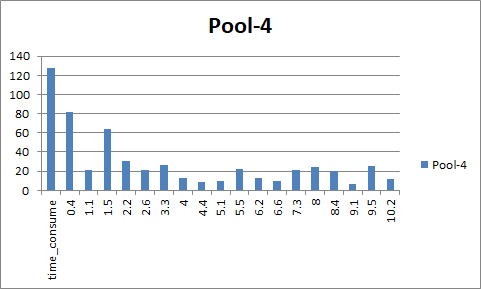

In [44]:
# 결과를 저장한다.

cols = ['time_span', 'P0_win', 'P1_win', 'delta_win', 'P0_rate','P1_rate', 'delta_rate',   ]
df_winning_rate01 = pd.DataFrame(win_rates01, columns=cols)
df_winning_rate02 = pd.DataFrame(win_rates02, columns=cols)
df_winning_rate04 = pd.DataFrame(win_rates04, columns=cols)

df_winning_rate01

,time_span,P0_win,P1_win,delta_win,P0_rate,P1_rate,delta_rate
0,0.1,4,0,4,100.000000,0.000000,100.000000
1,0.2,53,35,18,60.227273,39.772727,20.454545
2,0.3,49,44,5,52.688172,47.311828,5.376344
3,0.4,38,37,1,50.666667,49.333333,1.333333
4,0.5,49,43,6,53.260870,46.739130,6.521739
...,...,...,...,...,...,...,...
71,10.2,266,254,12,51.153846,48.846154,2.307692
72,10.3,266,252,14,51.351351,48.648649,2.702703
73,10.4,258,234,24,52.439024,47.560976,4.878049
74,10.5,215,199,16,51.932367,48.067633,3.864734


In [28]:
"""
# 1.6 < time < 2.0 시간대 경기수 count 정말 10경기밖에 없나?
# 정말 P0 이 7:3 으로 우세한 구간인가? 확인해 본다
"""

df_winning[
    (df_winning['time_consum'] > 1.6) & 
    (df_winning['time_consum'] <= 2.0) 
]

,time_consum,P0_win,P1_win
5766,2.0,0,1
21524,2.0,1,0
22951,2.0,1,0
24924,2.0,1,0
28473,2.0,1,0
29852,2.0,1,0
31191,2.0,1,0
33034,2.0,0,1
36480,2.0,1,0
38061,2.0,0,1


In [21]:
# csv 화일로 결과를 저장한다.
df_winning_rate01.to_csv(dir_base + remake + 'df_win_rate_every_10sec.csv')
df_winning_rate02.to_csv(dir_base + remake + 'df_win_rate_every_20sec.csv')
df_winning_rate04.to_csv(dir_base + remake + 'df_win_rate_every_40sec.csv')

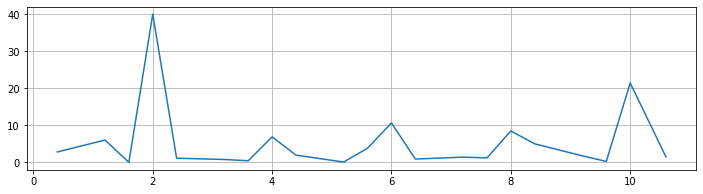

In [43]:
"""
# 10분 구간 승리카운트를 한 다음 경향을 보고 
"""
df= df_winning_rate04
y = df[['delta_rate']]
x = df['time_span']
plt.figure(figsize=(12,3))
plt.plot(x,y)
plt.grid()
plt.show()

In [ ]:
"""
# 10분 구간 승리카운트를 한 다음 경향을 보고 
"""

x = df_winning_rate['time_consume']
y = df_winning_rate['delta_win']

plt.figure(figsize=(12,5))
# plt.plot(x,y, alpha=0.6)
plt.bar(x, y, alpha=0.2)
plt.grid()
plt.show()

In [ ]:
df_winning_rate['percentile_win'].plot(x=x, y=y, rot=0, grid=True)

In [ ]:
df_winning_rate['delta_win'].plot.bar(x=x, y=y, rot=0)

In [ ]:
axes = df_winning_rate.plot.bar(rot=0, subplots=True)
axes[1].legend(loc=2)  

In [45]:
cols = [
    'time_consume',
    'delta_rate_pool4',
]

p0_rates_pool4 = {
     0.4 : 10.76923077,
     1.1 : 12.88888889,
     1.5 : 5.286343612,
     2.2 : 8.641975309,
     2.6 : 7.631318137,
     3.3 : 5.546492659,
     4.0 : 6.330837304,
     4.4 : 3.209019948,
     5.1 : 1.980830671,
     5.5 : 2.459396752,
     6.2 : 4,
     6.6 : 2.971175166,
     7.3 : 2.118644068,
     8.0 : 4.469273743,
     8.4 : 6.127352823,
     9.1 : 3.374578178,
     9.5 : 1.671938545,
    10.2 : 0.308153577,
    10.6 : 3.000545554,
}

In [47]:
df_new_rate04 = pd.DataFrame(p0_rates_pool4.items(), columns=cols)
df_new_rate04.to_csv(dir_base + remake + )

,time_consume,delta_rate_pool4
0,0.4,10.769231
1,1.1,12.888889
2,1.5,5.286344
3,2.2,8.641975
4,2.6,7.631318
5,3.3,5.546493
6,4.0,6.330837
7,4.4,3.209020
8,5.1,1.980831
9,5.5,2.459397


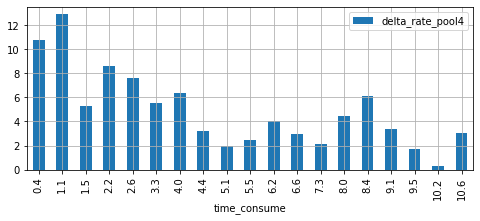

In [54]:
df_new_rate04.plot.bar(
        x='time_consume', y='delta_rate_pool4', 
        figsize=(8,3),
        grid=True
    )